In [ ]:
!pip install konlpy

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import re
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import os
import unicodedata
import urllib3
import zipfile

In [4]:
text = pd.read_excel('/content/drive/My Drive/Project/Seq To Seq/kor.xlsx', encoding='CP949')
text

,mid_sid,ko,en
0,1,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.
1,2,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here."
2,3,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.
3,4,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.
4,5,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.
...,...,...,...
74995,74996,나의 고민은 학교가 멀어서 통학하기 힘들어.,My worry is commuting to school because it's t...
74996,74997,난 지금 내고양이때문에 충분히 힘들어.,I am going under enough difficulties because o...
74997,74998,나와 대화가 어려운 것이 많이 힘들어?,Is having difficulties in talking with me too ...
74998,74999,하루에 한번 연락하는게 그렇게 힘들어?,Is it that difficult to call once a day?


In [5]:
df = text[['ko','en']]

df.shape

(75000, 2)

In [6]:
df.head()

,ko,en
0,나는 매일 저녁 배트를 만나러 다락방으로 가요.,I go to the attic every evening to meet Bat.
1,선생님 이문장이 이해가 안 가요.,"Sir, I don't understand this sentence here."
2,컴퓨터를 시작하면 시간이 너무 빠르게 가요.,Time flies when you start using the computer.
3,나는 오늘 자정에 한국으로 돌아 가요.,I'm going back to Korea today at midnight.
4,나는 일어나자마자 화장실에 가요.,I go to bathroom as soon as I wake up.


## 전처리

유니코드(Unicode) 문자열은 문자를 Unicode로 취급하기 때문에 영어나 한국어등의 ASCII 문자로 되어있어도 한 개 문자를 하나씩 다룹니다.

즉, 일반 문자열은 바이트 단위로 처리 하지만, 유니코드 문자열에서는 문자 단위로 처리하게 됩니다.

한글을 글자 깨짐 없이 사용하고 싶은 경우에는 유니코드 문자열을 사용하면 됩니다.

In [67]:
def unicode_to_ascii(s): 
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [68]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    # sent = unicode_to_ascii()

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [69]:
# 전처리 테스트
# 문자열 앞에 [u]또는 [U]를 붙여주면 유니코드 문자열이 됩니다.

kor_sent1 = u"저녁 먹었어?"
eng_sent1 = u"Have you had dinner?"

print(preprocess_sentence(eng_sent1))
print(preprocess_sentence(kor_sent1))

Have you had dinner ?
저녁 먹었어 ?


- 전체 데이터에서 33,000개의 샘플만 불러오되, 모든 전처리를 수행하는 함수를 만듭니다.   
- 또한 훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값에 해당되는 출력 시퀀스를 따로 분리하여 저장합니다.   
- 입력 시퀀스에는 시작을 의미하는 토큰인 \<sos\>를 추가하고, 출력 시퀀스에는 종료를 의미하는 토큰인 \<eos\>를 추가합니다  

In [70]:
len(df)

75000

In [71]:
def load_preprocessed_data(df):
    encoder_input, decoder_input, decoder_target = [], [], []
    for i in range(len(df)):
      src_line = df.iloc[i][0].strip()
      tar_line = df.iloc[i][1].strip()

      # source 데이터 전처리
      src_line_input = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_input = [w for w in ("<sos> " + tar_line).split()]
      tar_line_target = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line_input[::-1])
      decoder_input.append(tar_line_input)
      decoder_target.append(tar_line_target)

      # if i == num_samples - 1:
      #     break

    return encoder_input, decoder_input, decoder_target

In [72]:
# encoder_input, decoder_input, decoder_target
sents_kor_in, sents_eng_in, sents_eng_out = load_preprocessed_data(df)

In [73]:
print(sents_kor_in[-5:])
print(sents_eng_in[-5:])
print(sents_eng_out[-5:])

[['.', '힘들어', '통학하기', '멀어서', '학교가', '고민은', '나의'], ['.', '힘들어', '충분히', '내고양이때문에', '지금', '난'], ['?', '힘들어', '많이', '것이', '어려운', '대화가', '나와'], ['?', '힘들어', '그렇게', '연락하는게', '한번', '하루에'], ['.', '힘들죠', '많이', '즐기기엔', '스포츠를', '아이들이', '어린']]
[['<sos>', 'My', 'worry', 'is', 'commuting', 'to', 'school', 'because', 'it', 's', 'too', 'far', '.'], ['<sos>', 'I', 'am', 'going', 'under', 'enough', 'difficulties', 'because', 'of', 'my', 'cat', '.'], ['<sos>', 'Is', 'having', 'difficulties', 'in', 'talking', 'with', 'me', 'too', 'hard', 'for', 'you', '?'], ['<sos>', 'Is', 'it', 'that', 'difficult', 'to', 'call', 'once', 'a', 'day', '?'], ['<sos>', 'It', 'is', 'difficult', 'for', 'young', 'children', 'to', 'enjoy', 'sports', '.']]
[['My', 'worry', 'is', 'commuting', 'to', 'school', 'because', 'it', 's', 'too', 'far', '.', '<eos>'], ['I', 'am', 'going', 'under', 'enough', 'difficulties', 'because', 'of', 'my', 'cat', '.', '<eos>'], ['Is', 'having', 'difficulties', 'in', 'talking', 'with', 'me', 'too', 'har

In [74]:
# 인코딩
tokenizer_kor = Tokenizer()
tokenizer_kor.fit_on_texts(sents_kor_in)
encoder_input = tokenizer_kor.texts_to_sequences(sents_kor_in)

tokenizer_eng = Tokenizer(filters="", lower=True)
tokenizer_eng.fit_on_texts(sents_eng_in)
tokenizer_eng.fit_on_texts(sents_eng_out)
decoder_input = tokenizer_eng.texts_to_sequences(sents_eng_in)
decoder_target = tokenizer_eng.texts_to_sequences(sents_eng_out)

In [75]:
# 패딩
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

In [76]:
encoder_input.shape, decoder_input.shape, decoder_target.shape

((75000, 15), (75000, 19), (75000, 19))

In [77]:
src_vocab_size = len(tokenizer_kor.word_index) + 1
tar_vocab_size = len(tokenizer_eng.word_index) + 1
print("한국어 단어 집합의 크기 : {:d}, 영어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

한국어 단어 집합의 크기 : 85237, 영어 단어 집합의 크기 : 19285


In [78]:
encoder_input

array([[    1,   211, 29411, ...,     0,     0,     0],
       [    1,   211,    72, ...,     0,     0,     0],
       [    1,   211,   977, ...,     0,     0,     0],
       ...,
       [    2,  1307,    25, ...,     0,     0,     0],
       [    2,  1307,   232, ...,     0,     0,     0],
       [    1, 85236,    25, ...,     0,     0,     0]], dtype=int32)

In [79]:
src_to_index = tokenizer_kor.word_index
index_to_src = tokenizer_kor.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_eng.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_eng.index_word # 훈련 후 결과 비교할 때 사용

In [80]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[40930 29421 67701 ... 19158 17315  5627]


In [81]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [82]:
encoder_input[30997], decoder_input[30997], decoder_target[30997]

(array([    1,    24,   141,  6584,  2224,  3653, 70909, 28254,  6515,
           20,    75,   737,     0,     0,     0], dtype=int32),
 array([   2,  428,    4,   59,  224,   58, 1355,   50,   15, 4438,   14,
         346,    1,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([ 428,    4,   59,  224,   58, 1355,   50,   15, 4438,   14,  346,
           1,    3,    0,    0,    0,    0,    0,    0], dtype=int32))

In [83]:
n_of_val = int(len(df)*0.1)
print(n_of_val)

7500


In [84]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [85]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(67500, 15)
(67500, 19)
(67500, 19)
(7500, 15)
(7500, 19)
(7500, 19)


In [86]:
encoder_input_train

array([[    1,   305,  7502, ...,     0,     0,     0],
       [    2,  1505,    84, ...,     0,     0,     0],
       [    1, 79893, 27590, ...,     0,     0,     0],
       ...,
       [    1,    24,   141, ...,     0,     0,     0],
       [    1,   435, 27537, ...,     0,     0,     0],
       [    1,     7,   639, ...,     0,     0,     0]], dtype=int32)

## 기계 번역기 만들기

In [87]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [88]:
src_vocab_size

85237

In [89]:
latent_dim = 100

In [90]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
lstm = LSTM(latent_dim, return_state=True, return_sequences=True)(enc_masking)
lstm = LSTM(latent_dim, return_state=True, return_sequences=True)(lstm)
lstm = LSTM(latent_dim, return_state=True, return_sequences=True)(lstm)
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(lstm) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [92]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)(dec_masking, initial_state=encoder_states)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_lstm)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_lstm)
decoder_lstm_last = LSTM(latent_dim, return_sequences=True, return_state=True)
# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm_last(decoder_lstm)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [93]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

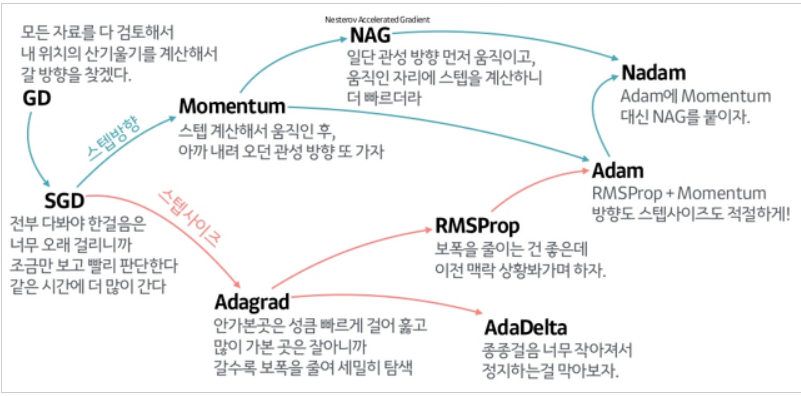

In [94]:
# # learning rate 조절하기 
# def scheduler(epoch, lr):
#   if epoch < 5:
#     return lr
#   else:
#     return lr/2*(epoch-5)

In [95]:
# from tensorflow.keras.optimizers import SGD
# epochs = 50
# learning_rate = 0.7
# model.compile(SGD(learning_rate=0.75), loss='sparse_categorical_crossentropy', metrics = ['acc'])

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
callbacks = [
             EarlyStopping(monitor ='val_acc', patience = 3),
             ]

In [98]:
def ready_callbacks(dir = './ckpt1'):
    import os #폴더 생성
    checkpoint_dir = dir
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=0),
        # This callback saves a SavedModel every 100 batches.
        # We include the training loss in the folder name.
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_dir + '/ckpt-loss={loss:.2f}',
            monitor='val_loss',
            save_best_only=True)
    ]
    return callbacks

In [96]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics = ['acc'])

In [ ]:
checkpoint_dir = './ckpt1'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=0),   
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + '/ckpt2-loss={loss:.4f}'
      )
    ]
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 35, callbacks = callbacks)

Epoch 1/35
528/528 [==============================] - 158s 299ms/step - loss: 2.4365 - acc: 0.6136 - val_loss: 2.3866 - val_acc: 0.6235
Epoch 2/35
528/528 [==============================] - 157s 297ms/step - loss: 2.2836 - acc: 0.6289 - val_loss: 2.2615 - val_acc: 0.6352
Epoch 3/35
528/528 [==============================] - 157s 297ms/step - loss: 2.1621 - acc: 0.6439 - val_loss: 2.1495 - val_acc: 0.6533
Epoch 4/35
528/528 [==============================] - 157s 298ms/step - loss: 2.0459 - acc: 0.6592 - val_loss: 2.0424 - val_acc: 0.6668
Epoch 5/35
528/528 [==============================] - 158s 299ms/step - loss: 1.9400 - acc: 0.6729 - val_loss: 1.9812 - val_acc: 0.6732
Epoch 6/35
528/528 [==============================] - 158s 298ms/step - loss: 1.8392 - acc: 0.6870 - val_loss: 1.8782 - val_acc: 0.6907
Epoch 7/35
528/528 [==============================] - 158s 299ms/step - loss: 1.7424 - acc: 0.7006 - val_loss: 1.7794 - val_acc: 0.7061
Epoch 8/35
528/528 [============================

## seq2seq 기계 번역기 동작시키기

In [ ]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

In [47]:
decoder_lstm_last[2]

<tf.Tensor 'lstm_11/PartitionedCall:3' shape=(None, 100) dtype=float32>

In [61]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm_last(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [62]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [63]:
decoder_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 100)    1928500     input_15[0][0]                   
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 100)]        0                                            
_______________________________________________________________________________________

In [64]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [65]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [66]:
for seq_index in [3,50,100,300,1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("원문 : ",seq2src(encoder_input_train[seq_index][::-1]))
  print("번역문 :",seq2tar(decoder_input_train[seq_index]))
  print("예측문 :",decoded_sentence[:-5])
  print("\n")

원문 :  그리고 카페에서 바리 스타로 일했어요 . 
번역문 : and i worked as a barista in a cafe . 
예측문 :  quesadilla quesadilla quesadilla quesadilla slave 


원문 :  한국에서 민주주의가 자리잡는데 몇 년이 걸릴 것이예요 . 
번역문 : it will take some year for democracy to settle in korea . 
예측문 :  quesadilla quesadilla quesadilla quesadilla slave 


원문 :  그는 목표를 달성하기 위해 자기가 할 수 있는 모든 일을 다했어요 . 
번역문 : he did everything within his power to achieve the goal . 
예측문 :  quesadilla quesadilla quesadilla quesadilla slave 


원문 :  오랜만에 잡채와 고추 튀김을 먹었어 . 
번역문 : i had japchae and fried peppers after a long time . 
예측문 :  quesadilla quesadilla quesadilla quesadilla slave 


원문 :  이 근처에 와인 바나 와인을 마실 수 있는 곳이 있나요 ? 
번역문 : is there a wine bar or somewhere i can drink wine nearby ? 
예측문 :  quesadilla quesadilla quesadilla quesadilla slave 


